# Forecasting & Inventory Alert System

An end-to-end ingredient demand forecasting & inventory alert system for a café, designed from raw transactional data to procurement signals

Creator: [Andrew Virya Victorio](https://avv.framer.website/) <br>
Email: [andrew.avv03@gmail.com](mailto:andrew.avv03@gmail.com) <br>
Repository: [github.com/AlphaByte-RedTeam/forecasting-inventory-alert-system](https://github.com/AlphaByte-RedTeam/forecasting-inventory-alert-system) <br>

Created date: Dec 17th, 2025

NB: This data is using a pre-processed and normalized datasets from local cafe nearby that cannot be disclosed. Thank you for understanding!

## Column Explanation

### 1. Sales Data
Filename: coffee_shop_sales.csv <br>
Grain: 1 row = 1 drink sold

| Column           | Explanation                                                |
| ---------------- | ---------------------------------------------------------- |
| `date`           | Date when the drink was sold                               |
| `product`        | Base beverage ordered                                      |
| `temperature`    | Serving type: hot or ice                                   |
| `sugar_level`    | Customer sugar preference (less / normal / extra)          |
| `ice_level`      | Ice quantity selected (none / less / normal)               |
| `coffee_used`    | Quantity of coffee beans used                              |
| `coffee_unit`    | Measurement unit for coffee (g)                            |
| `milk_used`      | Quantity of milk used                                      |
| `milk_unit`      | Measurement unit for milk (ml)                             |
| `chocolate_used` | Quantity of chocolate powder used                          |
| `chocolate_unit` | Measurement unit for chocolate (g)                         |
| `sugar_used`     | Quantity of sugar used                                     |
| `sugar_unit`     | Measurement unit for sugar (g)                             |
| `water_used`     | Quantity of water used                                     |
| `water_unit`     | Measurement unit for water (ml)                            |
| `is_weekend`     | Indicates if the sale occurred on a weekend                |
| `is_promo`       | Indicates if the sale occurred on a promo date (1.1–12.12) |

### 2. Ingredients Data
Filename: coffee_shop_inventory.csv <br>
Grain: 1 row = 1 ingredient per day

| Column            | Explanation                                     |
| ----------------- | ----------------------------------------------- |
| `date`            | Inventory snapshot date                         |
| `ingredient_name` | Ingredient identifier                           |
| `ingredient_unit` | Measurement unit of the ingredient              |
| `opening_stock`   | Stock level at the start of the day             |
| `used_today`      | Total ingredient usage for the day              |
| `closing_stock`   | Remaining stock after usage                     |
| `reorder_point`   | Stock threshold to trigger replenishment        |
| `lead_time_days`  | Supplier lead time in days                      |
| `reorder_flag`    | Indicates whether a reorder should be triggered |

Note: All ingredient quantities are stored with explicit unit columns to ensure safe aggregation, forecasting, and long-term schema extensibility.

## Load & read the dataset

In [1]:
import pandas as pd
import os

current_dir = os.getcwd()
dataset_dir = f'{current_dir}/datasets'

df_inventory = pd.read_csv(f'{dataset_dir}/coffee_shop_inventory.csv')
df_sales = pd.read_csv(f'{dataset_dir}/coffee_shop_sales.csv')

In [2]:
df_inventory.head()

,date,ingredient_name,ingredient_unit,opening_stock,used_today,closing_stock,reorder_point,lead_time_days,reorder_flag
0,2023-01-01,coffee,g,50000.0,3024.0,46976.0,15000,7,False
1,2023-01-01,milk,ml,200000.0,19360.0,180640.0,60000,3,False
2,2023-01-01,chocolate,g,30000.0,575.0,29425.0,8000,5,False
3,2023-01-01,sugar,g,40000.0,1872.5,38127.5,10000,4,False
4,2023-01-02,coffee,g,46976.0,2160.0,44816.0,15000,7,False


In [3]:
df_sales.head()

,date,product,temperature,sugar_level,ice_level,coffee_used,coffee_unit,milk_used,milk_unit,chocolate_used,chocolate_unit,sugar_used,sugar_unit,water_used,water_unit,is_weekend,is_promo
0,2023-01-01,Espresso,hot,normal,none,18,g,0,ml,0,g,10.0,g,30,ml,True,True
1,2023-01-01,Espresso,ice,normal,normal,18,g,0,ml,0,g,10.0,g,30,ml,True,True
2,2023-01-01,Espresso,hot,normal,none,18,g,0,ml,0,g,10.0,g,30,ml,True,True
3,2023-01-01,Espresso,ice,less,less,18,g,0,ml,0,g,7.5,g,30,ml,True,True
4,2023-01-01,Espresso,ice,normal,normal,18,g,0,ml,0,g,10.0,g,30,ml,True,True


## Data Quality & Validation

In [4]:
# Check datafram data types
df_inventory.dtypes

date                object
ingredient_name     object
ingredient_unit     object
opening_stock      float64
used_today         float64
closing_stock      float64
reorder_point        int64
lead_time_days       int64
reorder_flag          bool
dtype: object

In [5]:
df_sales.dtypes

date               object
product            object
temperature        object
sugar_level        object
ice_level          object
coffee_used         int64
coffee_unit        object
milk_used           int64
milk_unit          object
chocolate_used      int64
chocolate_unit     object
sugar_used        float64
sugar_unit         object
water_used          int64
water_unit         object
is_weekend           bool
is_promo             bool
dtype: object

In [6]:
# Check missing or null values from the dataset

inventory_na = df_inventory.columns[df_inventory.isna().any()].tolist()
inventory_null = df_inventory.columns[df_inventory.isnull().any()].tolist()

sales_na = df_sales.columns[df_sales.isna().any()].tolist()
sales_null = df_sales.columns[df_sales.isnull().any()].tolist()

print(f'Inventory NA: {inventory_na}')
print(f'Inventory NULL: {inventory_null}')
print(f'Sales NA: {sales_na}')
print(f'Sales NULL: {sales_null}')

Inventory NA: []
Inventory NULL: []
Sales NA: []
Sales NULL: []


In [7]:
# Check negative values
inventory_negative = df_inventory[(df_inventory.select_dtypes(include=['number']) < 0).any(axis=1)]
sales_negative = df_sales[(df_sales.select_dtypes(include=['number']) < 0).any(axis=1)]

print(f'Inventory Negative Values:\n{inventory_negative}')
print(f'Sales Negative Values:\n{sales_negative}')

Inventory Negative Values:
            date ingredient_name ingredient_unit  opening_stock  used_today  \
45    2023-01-12            milk              ml        13940.0     15520.0   
49    2023-01-13            milk              ml        -1580.0     19920.0   
53    2023-01-14            milk              ml       -21500.0     18380.0   
57    2023-01-15            milk              ml       -39880.0     17480.0   
61    2023-01-16            milk              ml       -57360.0     16580.0   
...          ...             ...             ...            ...         ...   
4255  2025-11-29           sugar               g     -1700903.0      1819.5   
4256  2025-11-30          coffee               g     -2751052.0      2772.0   
4257  2025-11-30            milk              ml    -17983180.0     17820.0   
4258  2025-11-30       chocolate               g      -482550.0       525.0   
4259  2025-11-30           sugar               g     -1702722.5      1754.5   

      closing_stock  reo

In [8]:
# Check all ingredient_name available
ingredients = set(df_inventory['ingredient_name'].unique().tolist())

# Grouping per date per ingredient name
daily_ingredients = df_inventory.groupby('date')['ingredient_name'].apply(set)

# Find dates with missing required ingredients
mismatched_dates = daily_ingredients[daily_ingredients != ingredients]
mismatched_dates.index.tolist()

[]

## Data Aggregation

In [9]:
# daily ingredient consumption
daily_consumption = df_inventory.groupby(['date', 'ingredient_name'])['used_today'].sum().unstack(fill_value=0)
daily_consumption.index = pd.to_datetime(daily_consumption.index)

daily_consumption.head()

ingredient_name,chocolate,coffee,milk,sugar
date,,,,
2023-01-01,575.0,3024.0,19360.0,1872.5
2023-01-02,550.0,2160.0,15020.0,1400.0
2023-01-03,600.0,2214.0,15720.0,1449.5
2023-01-04,500.0,2232.0,14440.0,1438.5
2023-01-05,425.0,2250.0,13900.0,1388.0


In [10]:
# sanity check
daily_consumption.loc["2023-01-02":"2023-01-08"].sum()

ingredient_name
chocolate      4275.0
coffee        17622.0
milk         120480.0
sugar         11435.0
dtype: float64

In [11]:
# weekly ingredient consumption
weekly_consumption = daily_consumption.resample('W-SUN').sum()
weekly_consumption.head()

ingredient_name,chocolate,coffee,milk,sugar
date,,,,
2023-01-01,575.0,3024.0,19360.0,1872.5
2023-01-08,4275.0,17622.0,120480.0,11435.0
2023-01-15,4325.0,17118.0,117520.0,11069.5
2023-01-22,3875.0,17676.0,115360.0,11175.5
2023-01-29,4025.0,16830.0,112000.0,10804.0


In [12]:
weekly_consumption.loc["2023-01-08"]

ingredient_name
chocolate      4275.0
coffee        17622.0
milk         120480.0
sugar         11435.0
Name: 2023-01-08 00:00:00, dtype: float64

In [13]:
# weekly ingredient consumption
monthly_consumption = daily_consumption.resample('ME').sum()
monthly_consumption.head()

ingredient_name,chocolate,coffee,milk,sugar
date,,,,
2023-01-31,18250.0,77022.0,517580.0,49405.0
2023-02-28,18350.0,70542.0,479560.0,46000.5
2023-03-31,17225.0,79920.0,514960.0,50745.5
2023-04-30,13875.0,81108.0,503100.0,50168.0
2023-05-31,12650.0,82962.0,502900.0,50513.0


In [14]:
# Check supplier lead time days per ingredient
df_inventory.groupby('ingredient_name')['lead_time_days'].max().sort_values()

ingredient_name
milk         3
sugar        4
chocolate    5
coffee       7
Name: lead_time_days, dtype: int64

In [15]:
# Create daily demand metrics per ingredient
daily_demand_metrics = pd.DataFrame()
daily_demand_metrics['mean_daily_consumption'] = daily_consumption.mean()
daily_demand_metrics['std_daily_consumption'] = daily_consumption.std()
daily_demand_metrics['max_daily_consumption'] = daily_consumption.max()
daily_demand_metrics['min_daily_consumption'] = daily_consumption.min()
daily_demand_metrics

,mean_daily_consumption,std_daily_consumption,max_daily_consumption,min_daily_consumption
ingredient_name,,,,
chocolate,481.760563,144.255035,1000.0,150.0
coffee,2632.698592,314.217659,3564.0,1962.0
milk,17090.140845,2148.411215,23420.0,12000.0
sugar,1638.006573,189.046471,2200.0,1207.5


In [16]:
# group sales data to get total ingredients used per day per product configuration
df_sales_grouped = df_sales.groupby(['date', 'product', 'temperature', 'sugar_level', 'ice_level']).agg({
    'coffee_used': 'sum',
    'milk_used': 'sum',
    'chocolate_used': 'sum',
    'sugar_used': 'sum',
    'water_used': 'sum'
}).reset_index()

df_sales_grouped

,date,product,temperature,sugar_level,ice_level,coffee_used,milk_used,chocolate_used,sugar_used,water_used
0,2023-01-01,Americano,hot,extra,none,54,0,0,36.0,540
1,2023-01-01,Americano,hot,less,none,72,0,0,30.0,720
2,2023-01-01,Americano,hot,normal,none,162,0,0,90.0,1620
3,2023-01-01,Americano,ice,extra,less,54,0,0,36.0,540
4,2023-01-01,Americano,ice,extra,normal,90,0,0,60.0,900
...,...,...,...,...,...,...,...,...,...,...
41840,2025-11-30,Latte,ice,extra,normal,108,1080,0,72.0,180
41841,2025-11-30,Latte,ice,less,less,36,360,0,15.0,60
41842,2025-11-30,Latte,ice,less,normal,36,360,0,15.0,60
41843,2025-11-30,Latte,ice,normal,less,72,720,0,40.0,120


## Data Visualization and Correlation

In [17]:
# finding total sales count per product per day
daily_product_sales = df_sales.groupby(['date', 'product']).size().unstack(fill_value=0)
daily_product_sales.index = pd.to_datetime(daily_product_sales.index.get_level_values('date'))
daily_product_sales.head()

product,Americano,Cappuccino,Espresso,Hot Chocolate,Latte
date,,,,,
2023-01-01,45,45,26,23,52
2023-01-02,33,27,19,22,41
2023-01-03,33,31,19,24,40
2023-01-04,34,30,22,20,38
2023-01-05,37,32,19,17,37


In [18]:
monthly_sales_per_product = daily_product_sales.resample('ME').sum()

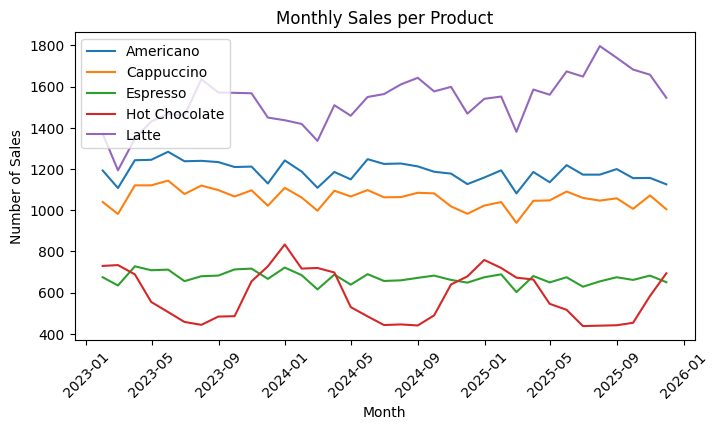

In [19]:
# visualize monthly sales products
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
for product in monthly_sales_per_product.columns:
    plt.plot(monthly_sales_per_product.index, monthly_sales_per_product[product], label=product)
plt.xlabel('Month')
plt.ylabel('Number of Sales')
plt.title('Monthly Sales per Product')
plt.legend()
plt.xticks(rotation=45)  
plt.show()

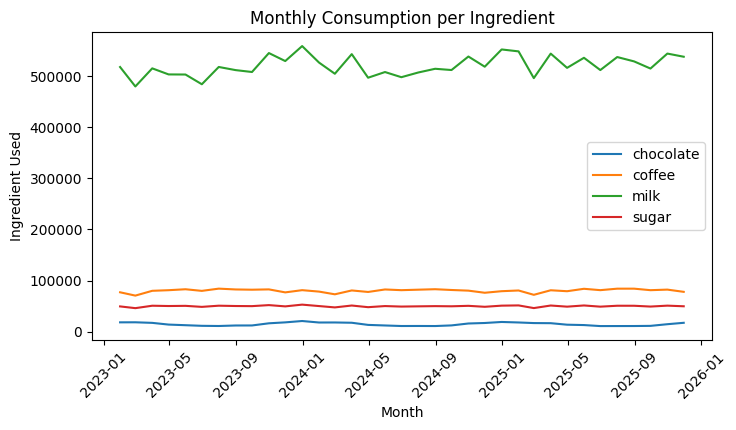

In [20]:
plt.figure(figsize=(8, 4))
for product in monthly_consumption.columns:
    plt.plot(monthly_consumption.index, monthly_consumption[product], label=product)
plt.xlabel('Month')
plt.ylabel('Ingredient Used')
plt.title('Monthly Consumption per Ingredient')
plt.legend()
plt.xticks(rotation=45)  
plt.show()

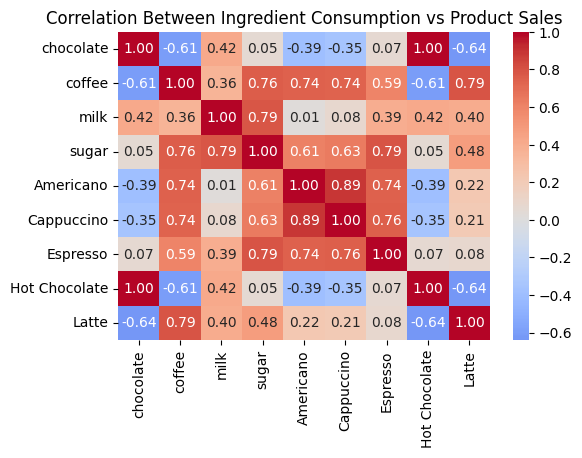

In [21]:
# create visual correlation matrix for ingredients consumption and sales
import seaborn as sns
monthly_consumption = monthly_consumption.sort_index()
monthly_sales_per_product = monthly_sales_per_product.sort_index()
combined_data = monthly_consumption.join(monthly_sales_per_product, how='inner', lsuffix='_consumption', rsuffix='_sales')
correlation_matrix = combined_data.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Between Ingredient Consumption vs Product Sales')
plt.show()